In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def read_avi(file):
    data=list()
    cap = cv2.VideoCapture(file)
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            frame=cv2.resize(frame,(320,240))
            frame=np.expand_dims(frame, axis=0)
            data.append(frame)
            cv2.waitKey(1)
        else:
            break
    cap.release()
    cv2.destroyAllWindows()
    return np.concatenate(data).astype('u1')

# data load

In [2]:
avi=read_avi("Head Thrust_HIT H.avi")
img=avi[:1]
gray=cv2.cvtColor(img[0],cv2.COLOR_BGR2GRAY)
img=img/255
gray=gray/255
img.shape,img.max()

((1, 240, 320, 3), 1.0)

## 눈깜빡임

In [3]:
model=tf.keras.models.load_model("../models/cnn_model_1_fold.h5",compile=False)

2022-11-15 10:17:30.174635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 10:17:30.181370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 10:17:30.181824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 10:17:30.183012: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
model.input,model.output

(<KerasTensor: shape=(None, 240, 320, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_1')>)

2022-11-15 10:17:31.290434: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


'open'

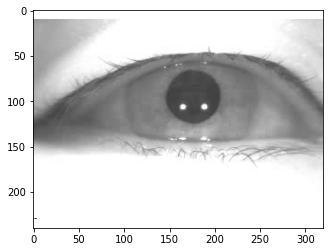

In [5]:
plt.imshow(img[0])
label=['open','closing','closed']
label[np.argmax(model(img))]

## Segmentation

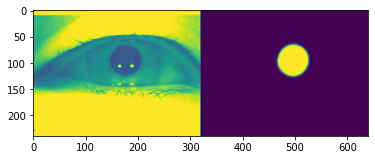

In [6]:
seg=tf.keras.models.load_model("../models/DeepVOG.h5",compile=False)
pred=seg.predict(img)[0,:,:,1]
plt.imshow(np.concatenate([gray,pred],axis=1))

## 수평수직

In [7]:
feature_extractor = tf.keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(240, 320, 3),
)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

inp=tf.keras.layers.Input((240,320,3))
pre_inp=preprocess_input(inp)
out=feature_extractor(pre_inp)
with tf.device("/cpu:0"):
    feature_model=tf.keras.Model(inp,out)
    feature_model.trainable=False

model=tf.keras.models.load_model("../models/cnn_rnn_model_1_fold.h5",compile=False)

87924736/87910968 [==============================] - 1s 0us/step


In [8]:
img=np.zeros((125,240,320,3),dtype='u1')
img[:avi.shape[0],:,:,:]=avi[:125]
print(img.shape)

target_label1=np.array(['left','mid','right'])
target_label2=np.array(['up','mid','down'])

feature=feature_model(img)
pred_h,pred_v=model.predict(feature[np.newaxis])

target_label1[np.argmax(pred_h)], target_label2[np.argmax(pred_v)]

(125, 240, 320, 3)


2022-11-15 10:17:37.017006: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-15 10:17:37.017094: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-15 10:17:37.017105: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-15 10:17:37.017112: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

('left', 'up')

## 진단

In [9]:
import pandas as pd
import joblib
X=pd.DataFrame({"age":18,"F":0,"M":[1]})
feature_df=pd.read_csv("ICS_patient_000973cf4af65c368a8797d9614888b2.tsv",sep='\t')
feature_df.head(1)

,Patient ID,Trial Number,Test Date,Test Type,Direction,Gain,Overt Saccades,Eye,Head,Gain Type,Saccadic Type
0,ICS_patient_000973cf4af65c368a8797d9614888b2,1,10/12/2018 2:36:10 PM,Head Impulse Lateral,Left,1.0,0.0,"['-7.70652401451883', '-12.0597458376507', '-1...","['-7.69491527992002', '-7.56063793617002', '-7...",Normal,Normal


In [10]:
X.loc[:,['LA','LP','Left','RA','RP','Right']]=feature_df[['Direction','Gain']].groupby(['Direction']).mean().T.values
X

,age,F,M,LA,LP,Left,RA,RP,Right
0,18,0,1,0.828,0.874,0.9955,0.958889,0.971,1.077


In [11]:
joblib.load('../models/lgbm_1_fold.pkl').predict(X)

array(['Peripheral type'], dtype=object)